In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


import sys
sys.path.append('../')
from utils import *

In [2]:
train_feats = pd.read_csv('../kaggle feat_eng/silver_bullet_feats_corrected.csv')

## Replace infs

In [3]:
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [4]:
# for col in train_feats.columns:
#     if len(train_feats[col].unique()) == 1:
#         train_feats.drop(col,inplace=True,axis=1)

# len(train_feats.columns)

## Training

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.10,random_state=41)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.6,0.8,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.6,0.8,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20,25,30]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 41,
        "n_estimators" : 1000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], #verbose=False,
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [6]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [7]:
# study.trials_dataframe().sort_values(by='value', ascending=True)

## Use best params

In [8]:
# best_trial = {'reg_lambda': 0.01873160320140423, 'reg_alpha': 0.006342560121043019, 'colsample_bytree': 0.6, 'colsample_bynode': 1.0, 'subsample': 0.9, 'learning_rate': 0.03286970460001816, 'max_depth': 20, 'min_child_samples': 30, 'num_leaves': 10}

In [9]:
# best_trial = study.best_trial.params
# print(best_trial)

In [11]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(1):
    kf = model_selection.KFold(n_splits=5, random_state=41 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler(feature_range=(-1, 1))

        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        # y_train[y_train['score']==0.5] = 1
        # y_train[y_train['score']==6] = 5.5
        X_train = imputer.fit_transform(X_train)
        X_train = scaler.fit_transform(X_train)
        y_train['score'] = y_train['score'] + np.random.normal(0, 0.05)
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        X_valid = imputer.fit_transform(X_valid)
        X_valid = scaler.transform(X_valid)

        model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
        
        model.fit(X_train, y_train)

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\v

In [12]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.62981


In [13]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [14]:
import math
def round_to_half(numbers, round_up=False):
    if round_up:
        return [round(num * 2) / 2 for num in numbers]
    else:
        return [math.floor(num * 2) / 2 for num in numbers]

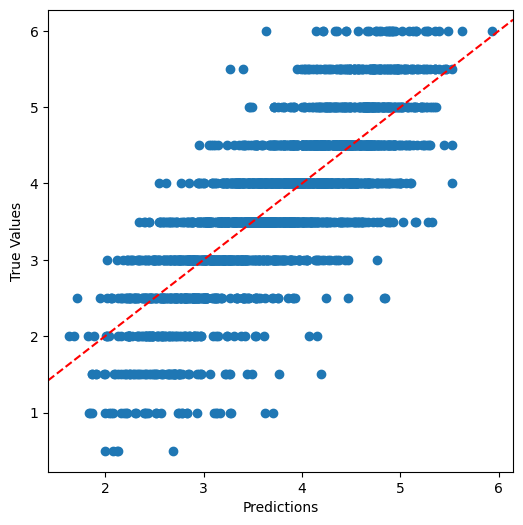

In [15]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

In [ ]:
out = pd.DataFrame()
out['id'] = train_feats['id']
out['pred'] = means
# out.to_csv('lgbm_v2_features0.csv', index=False)

## Analyze models

In [ ]:
split_importance = models_dict['0_0'].feature_importances_

# Plot feature importance using Gain
# lgb.plot_importance(models_dict['0_0'], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
# plt.show()

In [ ]:
dict_ = {}
for feat in train_cols:
    dict_[feat] = 0

for i in models_dict:
    for count, feat in enumerate(train_cols):
        dict_[feat] += models_dict[i].feature_importances_[count]

In [ ]:
cols[[key for key, value in dict_.items() if value == 0]].tolist()

['down_event_14_cnt',
 'up_event_0_cnt',
 'up_event_1_cnt',
 'up_event_2_cnt',
 'up_event_3_cnt',
 'up_event_4_cnt',
 'up_event_5_cnt',
 'up_event_6_cnt',
 'up_event_7_cnt',
 'up_event_8_cnt',
 'up_event_9_cnt',
 'up_event_10_cnt',
 'up_event_11_cnt',
 'up_event_12_cnt',
 'up_event_13_cnt',
 'up_event_14_cnt',
 'action_time_min',
 'cursor_position_min']

In [ ]:
split_importance_df = pd.DataFrame({'Feature': train_cols, 'Split': split_importance})
print(split_importance_df.sort_values(by='Split', ascending=False).tail(20))

    Feature  Split
59       59      1
36       36      0
34       34      0
76       76      0
50       50      0
85       85      0
49       49      0
48       48      0
47       47      0
46       46      0
45       45      0
44       44      0
43       43      0
77       77      0
42       42      0
41       41      0
40       40      0
39       39      0
38       38      0
37       37      0


In [ ]:
import sys

sys.exit()

SystemExit: 

C:\Users\luis.pinto1\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
outlier_df = pd.DataFrame()
outlier_df['id'] = train_feats['id']
outlier_df['score'] = train_feats['score']
outlier_df['preds'] = means

In [ ]:
# Define the near-miss range
near_miss_range = (1.5, 2.0)

secondary_model_data = outlier_df[
    (outlier_df['score'] < 1.5) |
    (outlier_df['preds'].between(near_miss_range[0], near_miss_range[1]))
].copy()

# Create a binary target for the secondary model
secondary_model_data['binary_target'] = (secondary_model_data['score'] < 1.5).astype(int)

## Classifier

In [ ]:
secondary_model_data = train_feats.copy()
secondary_model_data['score'] = (secondary_model_data['score']<=2).astype(int)

In [ ]:
#secondary_model_data.drop(['score','preds'],axis=1).merge(train_feats.drop(['score'],axis=1), on='id', how='left').rename({'binary_target':'score'}, axis=1)

In [ ]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in secondary_model_data.columns if col not in target_col + drop_cols]

def objective(trial,data=secondary_model_data[train_cols],target=secondary_model_data[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.6,0.8,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.6,0.8,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20,25,30]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "binary",
        "metric": "auc",
        'random_state': 42,
        "n_estimators" : 1000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(10, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], #verbose=False,
                callbacks=[early_stopping_callback], eval_metric='auc-pr'
    )
    
    preds = model.predict(test_x)
    
    aucpr = metrics.average_precision_score(test_y, preds)
    
    return aucpr

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
OOF_CLASSIFIER_PREDS = np.zeros((len(secondary_model_data), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in secondary_model_data['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5):
    kf = model_selection.KFold(n_splits=5, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(secondary_model_data.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        # X_train.fillna(0, inplace=True)
        # X_valid.fillna(0, inplace=True)
        best_trial = study.best_trial.params
        best_params = {
                "objective": "binary",
                "metric": "auc",
                'random_state': 42,
                "n_estimators" : 1000,
                "verbosity": -1,
                "n_jobs": -1,
                # **best_trial
            }
        model = lgb.LGBMClassifier(**best_params)
        early_stopping_callback = lgb.early_stopping(5, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], #verbose=False, 
                  callbacks=[early_stopping_callback],
                  eval_metric='auc-pr'
        )

        # Logistic regression
        # model = linear_model.LogisticRegression()
        # model.fit(X_train, y_train)

        valid_predict = model.predict_proba(X_valid)[:,1]

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_CLASSIFIER_PREDS[valid_idx, 0] = valid_predict 
        score = metrics.average_precision_score(y_valid, valid_predict)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.average_precision_score(secondary_model_data[target_col], oof_valid_preds)
    scores.append(oof_score)

c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310

In [ ]:
class_means = []
class_stds = []

for idx in preds_dict:
    class_means.append(np.mean(preds_dict[idx]))
    class_stds.append(np.std(preds_dict[idx]))

print('OOF AUC-PR metric LGBM = {:.5f}'.format(metrics.average_precision_score(secondary_model_data[target_col], 
                                                                   class_means)))

OOF AUC-PR metric LGBM = 0.54355


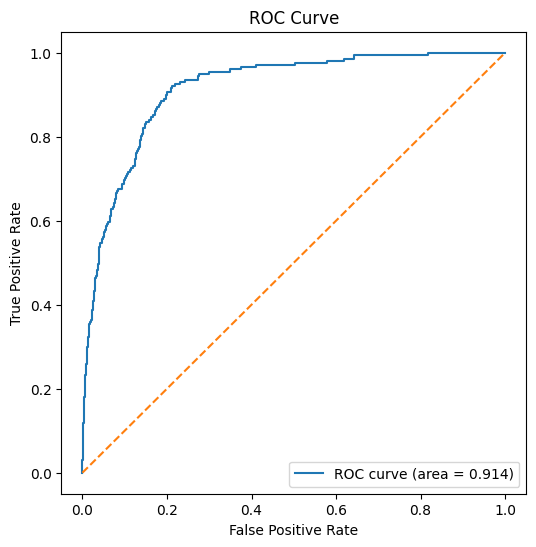

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(secondary_model_data[target_col], class_means)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(sum(tpr<0.90))

230


In [ ]:
thresholds[np.argmax(np.sqrt(tpr*(1-fpr)))]

0.05756903201104489

Text(0.5, 1.0, 'AUC-PR=0.543549013200823')

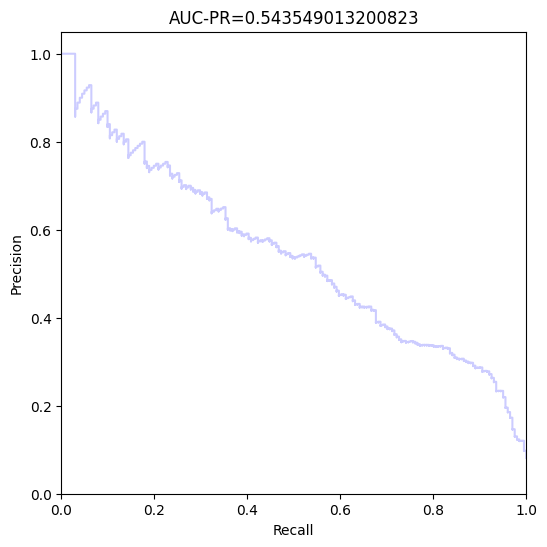

In [ ]:
precision, recall, _ = metrics.precision_recall_curve(secondary_model_data[target_col], class_means)
average_precision = metrics.average_precision_score(secondary_model_data[target_col], class_means)

plt.figure(figsize=(6,6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'AUC-PR={average_precision}')

In [ ]:
train_feats['reg_preds'] = means
train_feats['class_preds'] = class_means

In [ ]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   train_feats['reg_preds'],
                                                                   squared=False)))

print('OOF AUC-PR metric LGBM = {:.5f}'.format(metrics.average_precision_score(secondary_model_data[target_col], 
                                                                   class_means)))

OOF metric LGBM = 0.61091
OOF AUC-PR metric LGBM = 0.54355


In [ ]:
opt_thresh = thresholds[np.argmax(tpr - fpr)]
print(opt_thresh)
train_feats.loc[(train_feats['reg_preds']<=2) & (train_feats['class_preds']<=opt_thresh), 'reg_preds'] = 2

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   train_feats['reg_preds'],
                                                                   squared=False)))

0.05756903201104489
OOF metric LGBM = 0.61091


In [ ]:
train_feats[(train_feats['reg_preds']<=2) & (train_feats['class_preds']<=thresholds[230])]

,id,0,1,2,3,4,5,6,7,8,...,185,186,187,188,189,190,191,score,reg_preds,class_preds


In [ ]:
thresholds[230]

0.060138565850427164

In [ ]:
import sys

sys.exit()

SystemExit: 

C:\Users\luis.pinto1\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Reduced feature list

In [ ]:
temp_cols = []
for k in models_dict.keys():
    temp = models_dict[k].feature_importances_
    temp_df = pd.DataFrame({'Feature': train_cols, 'Split': temp})
    temp_cols+=list(temp_df.sort_values(by='Split', ascending=False).loc[:np.ceil(temp_df.shape[0]*0.75)]['Feature'].values)
# list(split_importance_df.sort_values(by='Split', ascending=False).loc[:np.ceil(split_importance_df.shape[0]*0.75)]['Feature'].values)

new_train_cols = list(set(temp_cols))

In [ ]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in new_train_cols if col not in target_col + drop_cols]

In [ ]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [9,11,13,15,17,20,25,30,35,40,45,50]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 40, step=2)
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': 42,
        "n_estimators" : 10000,
        "verbosity": -1,
        "n_jobs": -1,
        # "device_type": 'cuda',
        # "gpu_use_dp": True,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)

    early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)],  
                callbacks=[early_stopping_callback],
    )
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-04 22:42:44,426] A new study created in memory with name: no-name-277e7e2c-5f76-42c5-b825-11c304a3ef71
[I 2023-12-04 22:43:04,538] Trial 0 finished with value: 0.5835678813677481 and parameters: {'reg_lambda': 1.2416310682730105, 'reg_alpha': 0.9207298246650865, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.004329552883749802, 'max_depth': 40, 'min_child_samples': 50, 'num_leaves': 14}. Best is trial 0 with value: 0.5835678813677481.
[I 2023-12-04 22:43:57,942] Trial 1 finished with value: 0.5827234682003812 and parameters: {'reg_lambda': 0.03435274262778796, 'reg_alpha': 2.4275459985516226, 'colsample_bytree': 0.5, 'colsample_bynode': 0.7, 'subsample': 1.0, 'learning_rate': 0.000952795712114569, 'max_depth': 13, 'min_child_samples': 15, 'num_leaves': 10}. Best is trial 1 with value: 0.5827234682003812.
[I 2023-12-04 22:47:27,292] Trial 2 finished with value: 0.6074392976181612 and parameters: {'reg_lambda': 0.03254739626141539, 'reg_

Number of finished trials: 150
Best trial: {'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [ ]:
study.trials_dataframe().sort_values(by='value', ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bynode,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
145,145,0.574076,2023-12-04 23:40:37.223060,2023-12-04 23:40:43.394825,0 days 00:00:06.171765,0.9,0.6,0.017699,30,9,12,3.194365,0.342980,0.9,COMPLETE
54,54,0.575652,2023-12-04 23:21:02.652005,2023-12-04 23:21:14.556557,0 days 00:00:11.904552,1.0,0.4,0.007230,45,17,10,6.917574,0.117548,0.9,COMPLETE
124,124,0.575964,2023-12-04 23:36:16.817280,2023-12-04 23:36:30.947154,0 days 00:00:14.129874,1.0,0.4,0.005969,30,9,12,9.963699,0.276488,0.9,COMPLETE
136,136,0.576182,2023-12-04 23:39:23.976717,2023-12-04 23:39:35.093411,0 days 00:00:11.116694,1.0,0.6,0.012647,30,9,10,6.314529,0.974768,0.9,COMPLETE
125,125,0.576728,2023-12-04 23:36:30.948154,2023-12-04 23:36:48.521055,0 days 00:00:17.572901,1.0,0.8,0.008223,13,9,14,8.465590,0.342354,0.9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,0.593613,2023-12-04 22:57:26.264460,2023-12-04 22:57:36.510887,0 days 00:00:10.246427,0.7,0.8,0.029422,11,25,28,0.000383,0.003108,0.6,COMPLETE
2,2,0.607439,2023-12-04 22:43:57.943956,2023-12-04 22:47:27.291668,0 days 00:03:29.347712,1.0,1.0,0.000211,9,40,14,0.255294,0.032547,0.6,COMPLETE
9,9,0.644155,2023-12-04 22:57:43.159823,2023-12-04 23:05:35.025058,0 days 00:07:51.865235,0.9,0.7,0.000137,45,15,36,0.000120,0.005253,1.0,COMPLETE
4,4,0.665031,2023-12-04 22:47:42.165219,2023-12-04 22:51:22.048615,0 days 00:03:39.883396,0.5,0.8,0.000117,9,40,18,0.009382,0.000190,1.0,COMPLETE


## Test best model

In [ ]:
len(train_cols)

3209

In [ ]:
import pickle

with open('reduced_train_cols.pkl', 'wb') as f:
    pickle.dump(train_cols, f)

In [ ]:
best_trial = study.best_trial.params
print(best_trial)

{'reg_lambda': 0.3429800108155362, 'reg_alpha': 3.194364511840987, 'colsample_bytree': 0.6, 'colsample_bynode': 0.9, 'subsample': 0.9, 'learning_rate': 0.017699188262384626, 'max_depth': 30, 'min_child_samples': 9, 'num_leaves': 12}


In [ ]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 42,
                "n_estimators" : 10000,
                "verbosity": -1,
                "n_jobs": -1,
                **best_trial
            }
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [ ]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))
    
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric LGBM = 0.61374


## Quantiles

In [ ]:
# OOF_PREDS1 = np.zeros((len(train_feats), 1))
# OOF_PREDS2 = np.zeros((len(train_feats), 1))
# OOF_PREDS3 = np.zeros((len(train_feats), 1))
# # TEST_PREDS = np.zeros((len(test_feats), 2))

# models_dict = {}
# scores = []
# preds_dict = {}
# preds_dict['0.1'] = {}
# preds_dict['0.5'] = {}
# preds_dict['0.9'] = {}


# for i in [0.1,0.5,0.9]:
#     count = 0
#     for _ in train_logs_df['id'].unique():
#         preds_dict[str(i)][count] = []
#         count+=1

# # test_predict_list = []

# for i in range(5):
#     kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
#     oof_valid_preds = np.zeros(train_feats.shape[0])
#     # X_test = test_feats[train_cols]
#     for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
#         X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
#         X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
#         best_params = {
#                 "objective": "quantile",
#                 "metric": "rmse",
#                 'random_state': 42+i,
#                 # "n_estimators" : 12001,
#                 "verbosity": -1,
#                 "n_jobs": -1,
#                 **best_trial
#             }
        
#         for alpha_, oof_ in zip([0.1, 0.5, 0.9], [OOF_PREDS1, OOF_PREDS2, OOF_PREDS3]):
#             model = lgb.LGBMRegressor(**best_params, alpha=alpha_)
#             early_stopping_callback = lgb.early_stopping(50, first_metric_only=True, verbose=False)
            
#             model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
#                     callbacks=[early_stopping_callback],
#             )

#             valid_predict = model.predict(X_valid)

#             for count, idx in enumerate(valid_idx):
#                 preds_dict[str(alpha_)][idx].append(valid_predict[count])

#             # oof_valid_preds[valid_idx] = valid_predict
#             # OOF_PREDS[valid_idx, 0] += valid_predict / 5
#             oof_[valid_idx, 0] = valid_predict


#             # test_predict = model.predict(X_test)
#             # TEST_PREDS[:, 0] += test_predict / 5 / 10
#             # test_predict_list.append(test_predict)
#             # score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
#             models_dict[f'{fold}_{i}'] = model

#     # oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
#     # scores.append(oof_score)

In [ ]:
# means = []
# stds = []

# for idx in preds_dict['0.9']:
#     means.append(np.mean(preds_dict['0.9'][idx]))
#     stds.append(np.std(preds_dict['0.9'][idx]))

In [ ]:
# print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
#                                                                    means,
#                                                                    squared=False)))

OOF metric LGBM = 1.20673


## Analyze errors

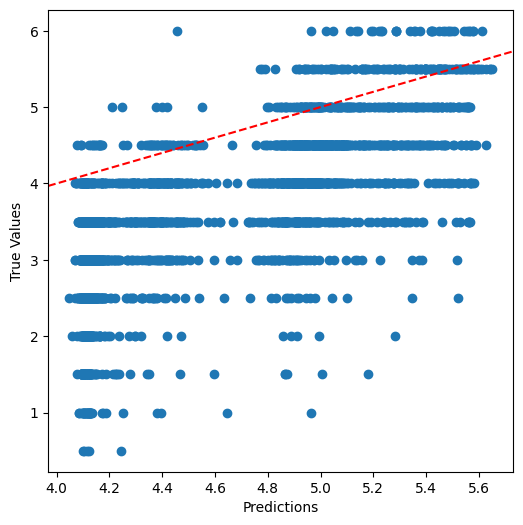

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([491., 955., 596., 248., 101.,  36.,  23.,  12.,   7.,   2.]),
 array([0.00259067, 0.01846898, 0.03434728, 0.05022559, 0.0661039 ,
        0.0819822 , 0.09786051, 0.11373881, 0.12961712, 0.14549542,
        0.16137373]),
 <BarContainer object of 10 artists>)

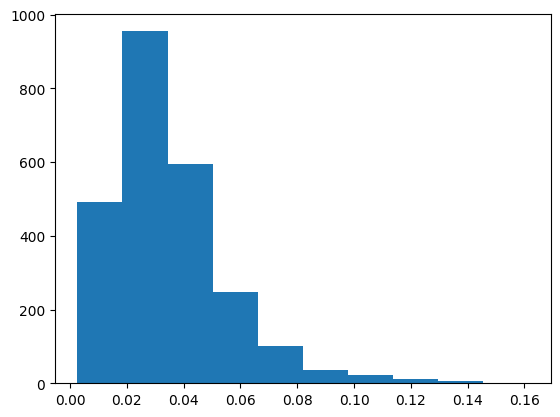

In [ ]:
plt.hist(stds)

In [ ]:
x = pd.DataFrame()
x['means'] = means
x['stds'] = stds
x['target'] = train_scores_df['score']

In [ ]:
x['residuals'] = np.abs(x['means'] - x['target'])

In [ ]:
x.sort_values(by='stds', ascending=False, inplace=True)

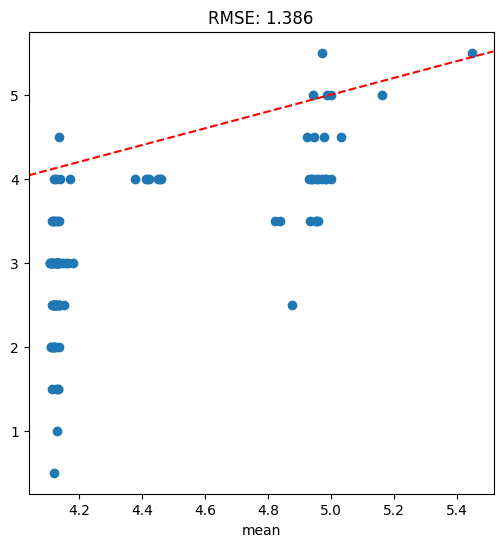

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

x_ = x['means'].tail(100)
# x_ = round_to_half(x_, round_up=True)
y = x['target'].tail(100)

mse = metrics.mean_squared_error(x_, y, squared=False)

ax.scatter(x_, y)
plt.xlabel('mean')
plt.title(f'RMSE: {mse:.3f}')
add_identity(ax, color='r', ls='--')
plt.show()